In [293]:
import pandas as pd

#import dataset from local device
url = "https://raw.githubusercontent.com/abinesht/datastorm/main/train_data.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19921 entries, 0 to 19920
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CategoryCode  19921 non-null  object
 1   ItemCode      19921 non-null  int64 
 2   DateID        19921 non-null  object
 3   DailySales    19921 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 622.7+ KB


In [294]:
from datetime import datetime

date_time_str = '14/02/22'

date_time_obj = datetime.strptime(date_time_str, '%d/%m/%y')
print(date_time_obj.strftime("%V"))

print ("The type of the date is now",  type(date_time_obj))
print ("The date is", date_time_obj)

df['date_format'] = pd.to_datetime(df['DateID'], format = '%m/%d/%Y',  errors = 'coerce')
df['year']=df['date_format'].dt.year
df['month']=df['date_format'].dt.month
df['week']= df['date_format'].dt.weekofyear
# df['day']=df['date_format'].dt.day


day_names = df['date_format'].dt.day_name()
df['is_weekend'] = day_names.apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
df.head()

df['CategoryCode']=df.CategoryCode.str.split(pat='_',expand=True)[1]

df.head(100)

07
The type of the date is now <class 'datetime.datetime'>
The date is 2022-02-14 00:00:00


C:\Users\Abi\AppData\Local\Temp/ipykernel_7504/2489002205.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week']= df['date_format'].dt.weekofyear


,CategoryCode,ItemCode,DateID,DailySales,date_format,year,month,week,is_weekend
0,2,117610,11/6/2021,7,2021-11-06,2021,11,44,1
1,4,836584,11/18/2021,16,2021-11-18,2021,11,46,0
2,1,370195,1/24/2022,6,2022-01-24,2022,1,4,0
3,2,172582,10/30/2021,5,2021-10-30,2021,10,43,1
4,2,1006009,10/30/2021,5,2021-10-30,2021,10,43,1
...,...,...,...,...,...,...,...,...,...
95,3,16936,11/17/2021,4,2021-11-17,2021,11,46,0
96,3,1060630,1/5/2022,2,2022-01-05,2022,1,1,0
97,1,1048975,11/18/2021,3,2021-11-18,2021,11,46,0
98,2,41830,2/9/2022,2,2022-02-09,2022,2,6,0


In [295]:
discrete_features = df.drop(columns=["DailySales","DateID","date_format"]).dtypes == int

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(df.drop(columns=["DailySales","DateID","date_format"]), df.DailySales, discrete_features)
mi_scores.sort_values(ascending=False)

ItemCode        0.297606
CategoryCode    0.052466
is_weekend      0.000053
year            0.000000
month           0.000000
week            0.000000
Name: MI Scores, dtype: float64

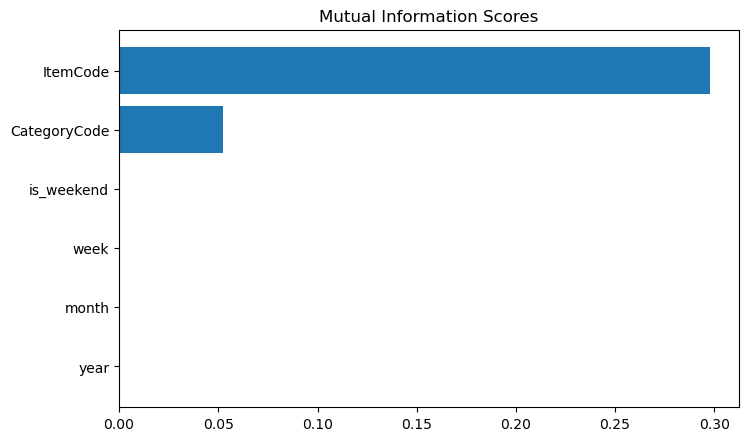

In [296]:
import numpy as np

import matplotlib.pyplot as plt
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [297]:
week_df = pd.DataFrame(columns = ['CategoryCode', 'ItemCode', 'Week','WeeklySales'])

gkk = df.groupby(['week','ItemCode'])
  
# Print the first value in each group
gkk.first()

for i,j in gkk:
  # print(i,j)
  sum = 0
  dict ={}
  for k in range(j.shape[0]):
    sum = sum + (int((j.iloc[[k]])['DailySales']))
  if  39 <= int((j.iloc[[k]])['week']) <=52:
    week = int((j.iloc[[k]])['week']) -38
  else:
    week = 14 + int((j.iloc[[k]])['week'])
  dict = {'CategoryCode': int((j.iloc[[k]])['CategoryCode']),'ItemCode':int((j.iloc[[k]])['ItemCode']) ,'Week':week,'WeeklySales' : sum}
  week_df=week_df.append(dict,ignore_index=True)

week_df

,CategoryCode,ItemCode,Week,WeeklySales
0,1,3418,15,83
1,1,3427,15,66
2,3,7666,15,15
3,2,9925,15,8
4,3,16936,15,74
...,...,...,...,...
3767,3,1101661,14,31
3768,2,1103056,14,14
3769,2,1105009,14,3
3770,2,1105018,14,15


In [298]:
discrete_features = week_df.drop(columns=["WeeklySales"]).dtypes == int

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(week_df.drop(columns=["WeeklySales"]), week_df.WeeklySales, discrete_features)
mi_scores.sort_values(ascending=False)

ItemCode        0.236135
CategoryCode    0.056286
Week            0.010073
Name: MI Scores, dtype: float64

No handles with labels found to put in legend.


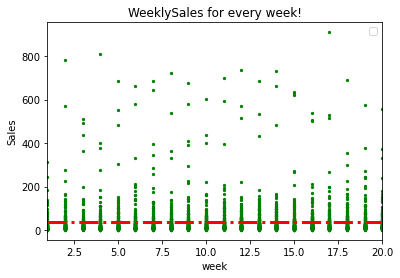

In [299]:
import matplotlib.pyplot as plt

 
# plotting points as a scatter plot
plt.scatter(week_df.Week, week_df.WeeklySales, color= "green",
            marker= ".", s=20)

# x-axis label
plt.xlim(1, 20)
plt.xlabel('week')
# frequency label
plt.ylabel('Sales')
# plot title
plt.title('WeeklySales for every week!')

# Plot the average line
plt.axhline(y=week_df.WeeklySales.mean(), color='r', linestyle='-.', linewidth=3)

# showing legend
plt.legend()

# function to show the plot
plt.show()

In [300]:
X = week_df.drop(columns=["WeeklySales"])
# X=df.tot_week
y=week_df.WeeklySales
y=y.astype('int')

In [301]:
validation_url = "https://raw.githubusercontent.com/abinesht/datastorm/main/validation_data.csv"
validation_df = pd.read_csv(validation_url)

validation_df['CategoryCode']=validation_df.CategoryCode.str.split(pat='_',expand=True)[1]

# for i in range(validation_df.shape[0]):
#   print(str((validation_df.iloc[[i]])['Week']))
#   if (str((validation_df.iloc[[i]])['Week']) == 'w1'):
#     print("yes")
#     break


for index, row in validation_df.iterrows():
  if (row['Week'] == 'w1'):
    row['Week'] = 21

  elif (row['Week'] == 'w2'):
    row['Week'] = 22

  elif (row['Week'] == 'w3'):
    row['Week'] = 23

  elif (row['Week'] == 'w4'):
    row['Week'] = 24



validation_df.replace("w1", 21,inplace=True)
validation_df.replace("w2", 22,inplace=True)
validation_df.replace("w3", 23,inplace=True)
validation_df.replace("w4", 24,inplace=True)
validation_df

,CategoryCode,ItemCode,Week,WeeklySales
0,2,1044502,21,11
1,2,1105009,21,11
2,2,913561,24,5
3,1,1048975,24,30
4,1,17287,22,60
...,...,...,...,...
365,2,124954,22,43
366,2,40759,21,48
367,1,1090303,21,19
368,2,1090276,23,6


In [302]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initialze the estimators
clf1 = RandomForestClassifier(max_depth=13, random_state=42, n_estimators= 50)
clf2 = RandomForestClassifier()

In [303]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


# week_df.sort_values(by=['Week'])
# X_train, X_test, y_train , y_test = train_test_split(X,y , test_size = 0.2, random_state=25)

X_train = week_df.drop(columns=['WeeklySales'])
y_train = week_df.WeeklySales.astype('int')

X_test = validation_df.drop(columns=['WeeklySales'])
y_test = validation_df.WeeklySales.astype('int')


clf1.fit(X_train,y_train)

y_pred = clf1.predict(X_test)

RF_score = mean_absolute_percentage_error(y_test, y_pred)
RF_score

1.0426734682333356

In [304]:
from sklearn import datasets,linear_model
from sklearn.tree import DecisionTreeClassifier

DT=DecisionTreeClassifier(max_depth=None,min_samples_split=10)


DT.fit(X_train,y_train)

y_pred = DT.predict(X_test)

DT_score = mean_absolute_percentage_error(y_test, y_pred)
DT_score

0.599360194050096

In [317]:
from sklearn.neighbors import KNeighborsClassifier

# gnb=GaussianNB()
# mnb=MultinomialNB()
knn=KNeighborsClassifier()

knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

KNN_score = mean_absolute_percentage_error(y_test, y_pred)
KNN_score

0.582407945785739

In [307]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB


svc = SVC(probability=True, random_state=42)
lr = LogisticRegression(random_state=42)
mnb = MultinomialNB()
gb = GradientBoostingClassifier(random_state=42)

svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
SVC_score = mean_absolute_percentage_error(y_test, y_pred)
print(SVC_score)

lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
LR_score = mean_absolute_percentage_error(y_test, y_pred)
print(LR_score)

mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
MNB_score = mean_absolute_percentage_error(y_test, y_pred)
print(MNB_score)

# gb.fit(X_train,y_train)
# y_pred = gb.predict(X_test)
# GB_score = mean_absolute_percentage_error(y_test, y_pred)
# print(GB_score)

0.719910726453372
0.7250876147220497
5.393975383809354


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [330]:
def show_plot(score_dict,color):
    models = list(score_dict.keys())
    scores = list(score_dict.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(models, scores, color =color, width = 0.4)

    plt.xlabel("Models")
    plt.ylabel("Scores")
    plt.title("MAPE for different models")
    plt.show()

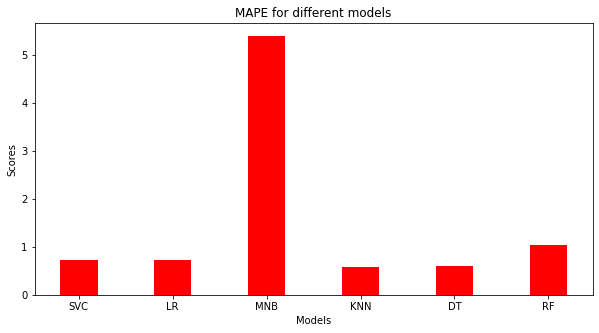

In [331]:
score_dict={}

score_dict['SVC']=SVC_score
score_dict['LR']=LR_score
# score_dict['GB']=GB_score
score_dict['MNB']=MNB_score
score_dict['KNN']=KNN_score
score_dict['DT']=DT_score
score_dict['RF']=RF_score

show_plot(score_dict,"red")

In [315]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# knn_pipe = Pipeline([('mms', MinMaxScaler()),
#                      ('knn', KNeighborsClassifier())])

# params = [{'knn__n_neighbors': [1 ,3 ,10, 20],
#          'knn__weights': ['uniform', 'distance'],
#          'knn__leaf_size': [5,10,15, 20,30,40]}]
# gs_knn = GridSearchCV(knn_pipe,
#                       param_grid=params,
#                       cv=5)
# gs_knn.fit(X_train, y_train)

# gs_knn.best_params_



In [ ]:
import sklearn

sklearn.metrics.SCORERS.keys()

In [314]:
param_grid = {'n_neighbors': [1 ,3 ,4,7,10, 20],'leaf_size': [5,10,15, 20,30,40]}

knn2 = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='neg_mean_absolute_percentage_error')
knn2.fit(X_train, y_train)

knn2.best_params_


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'leaf_size': 10, 'n_neighbors': 3}

In [318]:
knn2 = KNeighborsClassifier(n_neighbors=3)
knn2.fit(X_train,y_train)

y_pred = knn2.predict(X_test)

KNN_new = mean_absolute_percentage_error(y_test, y_pred)
KNN_new

0.5547904047675736

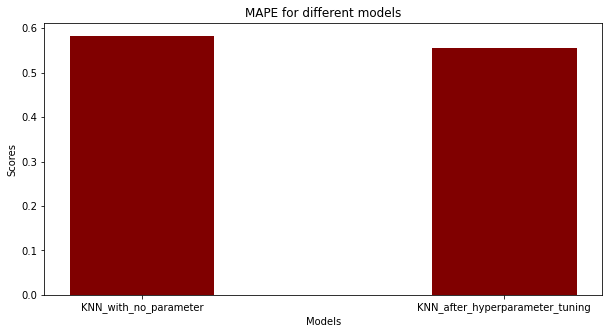

In [332]:
knn_scores = {"KNN_with_no_parameter":KNN_score, "KNN_after_hyperparameter_tuning":KNN_new}

show_plot(knn_scores,"maroon")

**## Ensemble**

In [ ]:
estimator = [] 
estimator.append(('DT',DecisionTreeClassifier())) 
estimator.append(('RF',RandomForestClassifier(max_depth=20, random_state=42, n_estimators= 1000))) 
estimator.append(('KNN',KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',metric_params=None, n_jobs=1, p=2, weights='uniform',n_neighbors=2))) 

In [323]:
from sklearn.ensemble import VotingClassifier

#hard voting
hard_voting = VotingClassifier(estimators = estimator, voting ='hard') 

hard_voting.fit(X_train,y_train)
y_pred = hard_voting.predict(X_test)

hard_voting_score = mean_absolute_percentage_error(y_test, y_pred)
print("hard_voting_score",hard_voting_score)

soft_voting = VotingClassifier(estimators = estimator, voting ='soft') 
soft_voting.fit(X_train,y_train)
y_pred = soft_voting.predict(X_test)

soft_voting_score = mean_absolute_percentage_error(y_test, y_pred)
print("soft_voting_score",soft_voting_score)

hard_voting_score 0.6247073753374861
soft_voting_score 0.6214961763336041


In [325]:
from sklearn.ensemble import StackingClassifier

stack_model = StackingClassifier(estimators=estimator)

stack_model.fit(X_train,y_train)
y_pred = stack_model.predict(X_test)

stack_model_score = mean_absolute_percentage_error(y_test, y_pred)
print("stack_model_score",stack_model_score)

C:\Users\Abi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:999: RuntimeWarning: Number of classes in training fold (233) does not match total number of classes (258). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn('Number of classes in training fold ({}) does '
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:999: RuntimeWarning: Number of classes in training fold (236) does not match total number of classes (258). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn('Number of classes in training fold (

stack_model_score 0.668490426401391


In [326]:
from sklearn.ensemble import BaggingClassifier

bagg_model = BaggingClassifier(base_estimator = knn2, n_estimators = 25, random_state = 42)

bagg_model.fit(X_train,y_train)

y_pred = bagg_model.predict(X_test)

bagg_model_score = mean_absolute_percentage_error(y_test, y_pred)
print("bagg_model_score",bagg_model_score)

bagg_model_score 0.6210822728877186


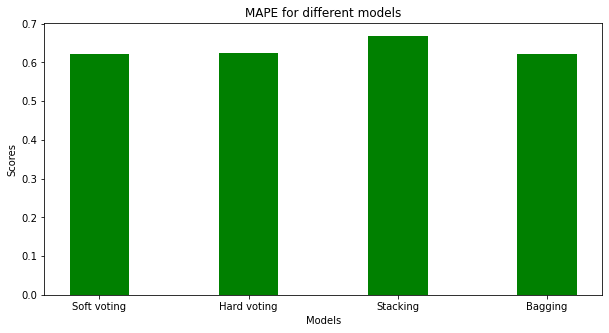

In [333]:
ensemble_scores = {"Soft voting":soft_voting_score, "Hard voting": hard_voting_score, "Stacking" : stack_model_score, "Bagging" : bagg_model_score}

show_plot(ensemble_scores,"green")

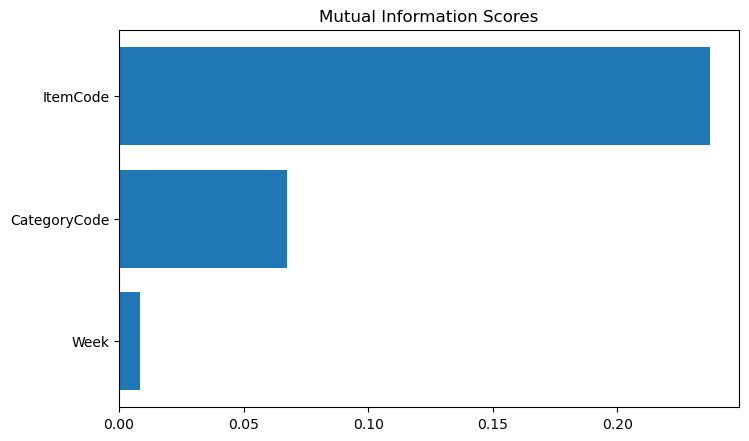

In [334]:
discrete_features = X.dtypes == int

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores.sort_values(ascending=False)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [336]:
test_url = "https://raw.githubusercontent.com/abinesht/datastorm/main/test_data.csv"

test_df = pd.read_csv(test_url)

test_df.replace("w1", 21,inplace=True)
test_df.replace("w2", 22,inplace=True)
test_df.replace("w3", 23,inplace=True)
test_df.replace("w4", 24,inplace=True)

test_df['CategoryCode']=test_df.CategoryCode.str.split(pat='_',expand=True)[1]

In [337]:
test_df

,CategoryCode,ItemCode,Week,PredictedSales
0,1,43738,24,NaN
1,2,1006090,21,NaN
2,2,1076929,24,NaN
3,1,1081321,23,NaN
4,2,216151,24,NaN
...,...,...,...,...
372,2,1101571,21,NaN
373,2,1090258,24,NaN
374,2,906595,21,NaN
375,2,32245,21,NaN


In [338]:
X_test = test_df.drop(columns=['PredictedSales'])

test_df['PredictedSales'] = knn.predict(X_test)

test_df


,CategoryCode,ItemCode,Week,PredictedSales
0,1,43738,24,17
1,2,1006090,21,15
2,2,1076929,24,6
3,1,1081321,23,2
4,2,216151,24,13
...,...,...,...,...
372,2,1101571,21,7
373,2,1090258,24,18
374,2,906595,21,7
375,2,32245,21,51


In [339]:
new_df = pd.DataFrame(columns = ['ID','WeeklySales'])

for index, row in test_df.iterrows():
  dic={}
  n = int(row['Week'])-20
  stri = "category_"+str(row['CategoryCode'])+"_"+str(row['ItemCode'])+"_w"+str(n)
  dict = {'ID':stri,'WeeklySales':int(row['PredictedSales'])}
  new_df=new_df.append(dict,ignore_index=True)

# from google.colab import files
# new_df.to_csv("forth_submission.csv", index = False)
# files.download('forth_submission.csv')
